# k-Nearest Neighbors

### Importing libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import statsmodels.api as sm
import padasip as pa

from sklearn.metrics import mean_squared_error, mean_absolute_error

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import datetime

import wandb
import logging
import os

from codecarbon import EmissionsTracker

c:\Users\Samsung\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold,TimeSeriesSplit
from sklearn import neighbors

from sklearn.neighbors import KNeighborsRegressor
%config IPCompleter.greedy=True

### Implemented modules and Padasip module

In [3]:
from padasip.filters.base_filter import AdaptiveFilter
from TedaEnsemble import DataCloud, TEDAEnsemble

from treating import dataTreating, dataSpliting, dataProcessing, dataSplit

## Data loading:

In [4]:
data = pd.read_csv("Electric_Production.csv")
data.rename(columns={'DATE':'Date', 'IPG2211A2N':'Production'}, inplace=True)
data.head()

#Variables
dataSeries = data["Production"]
date = "Date"

In [5]:
#RMSE and MAE Individual
RMSE_KNN = []
MAE_KNN = []

In [6]:
# Variables
window_ = 2
neighbors_ = 2

### Visualization

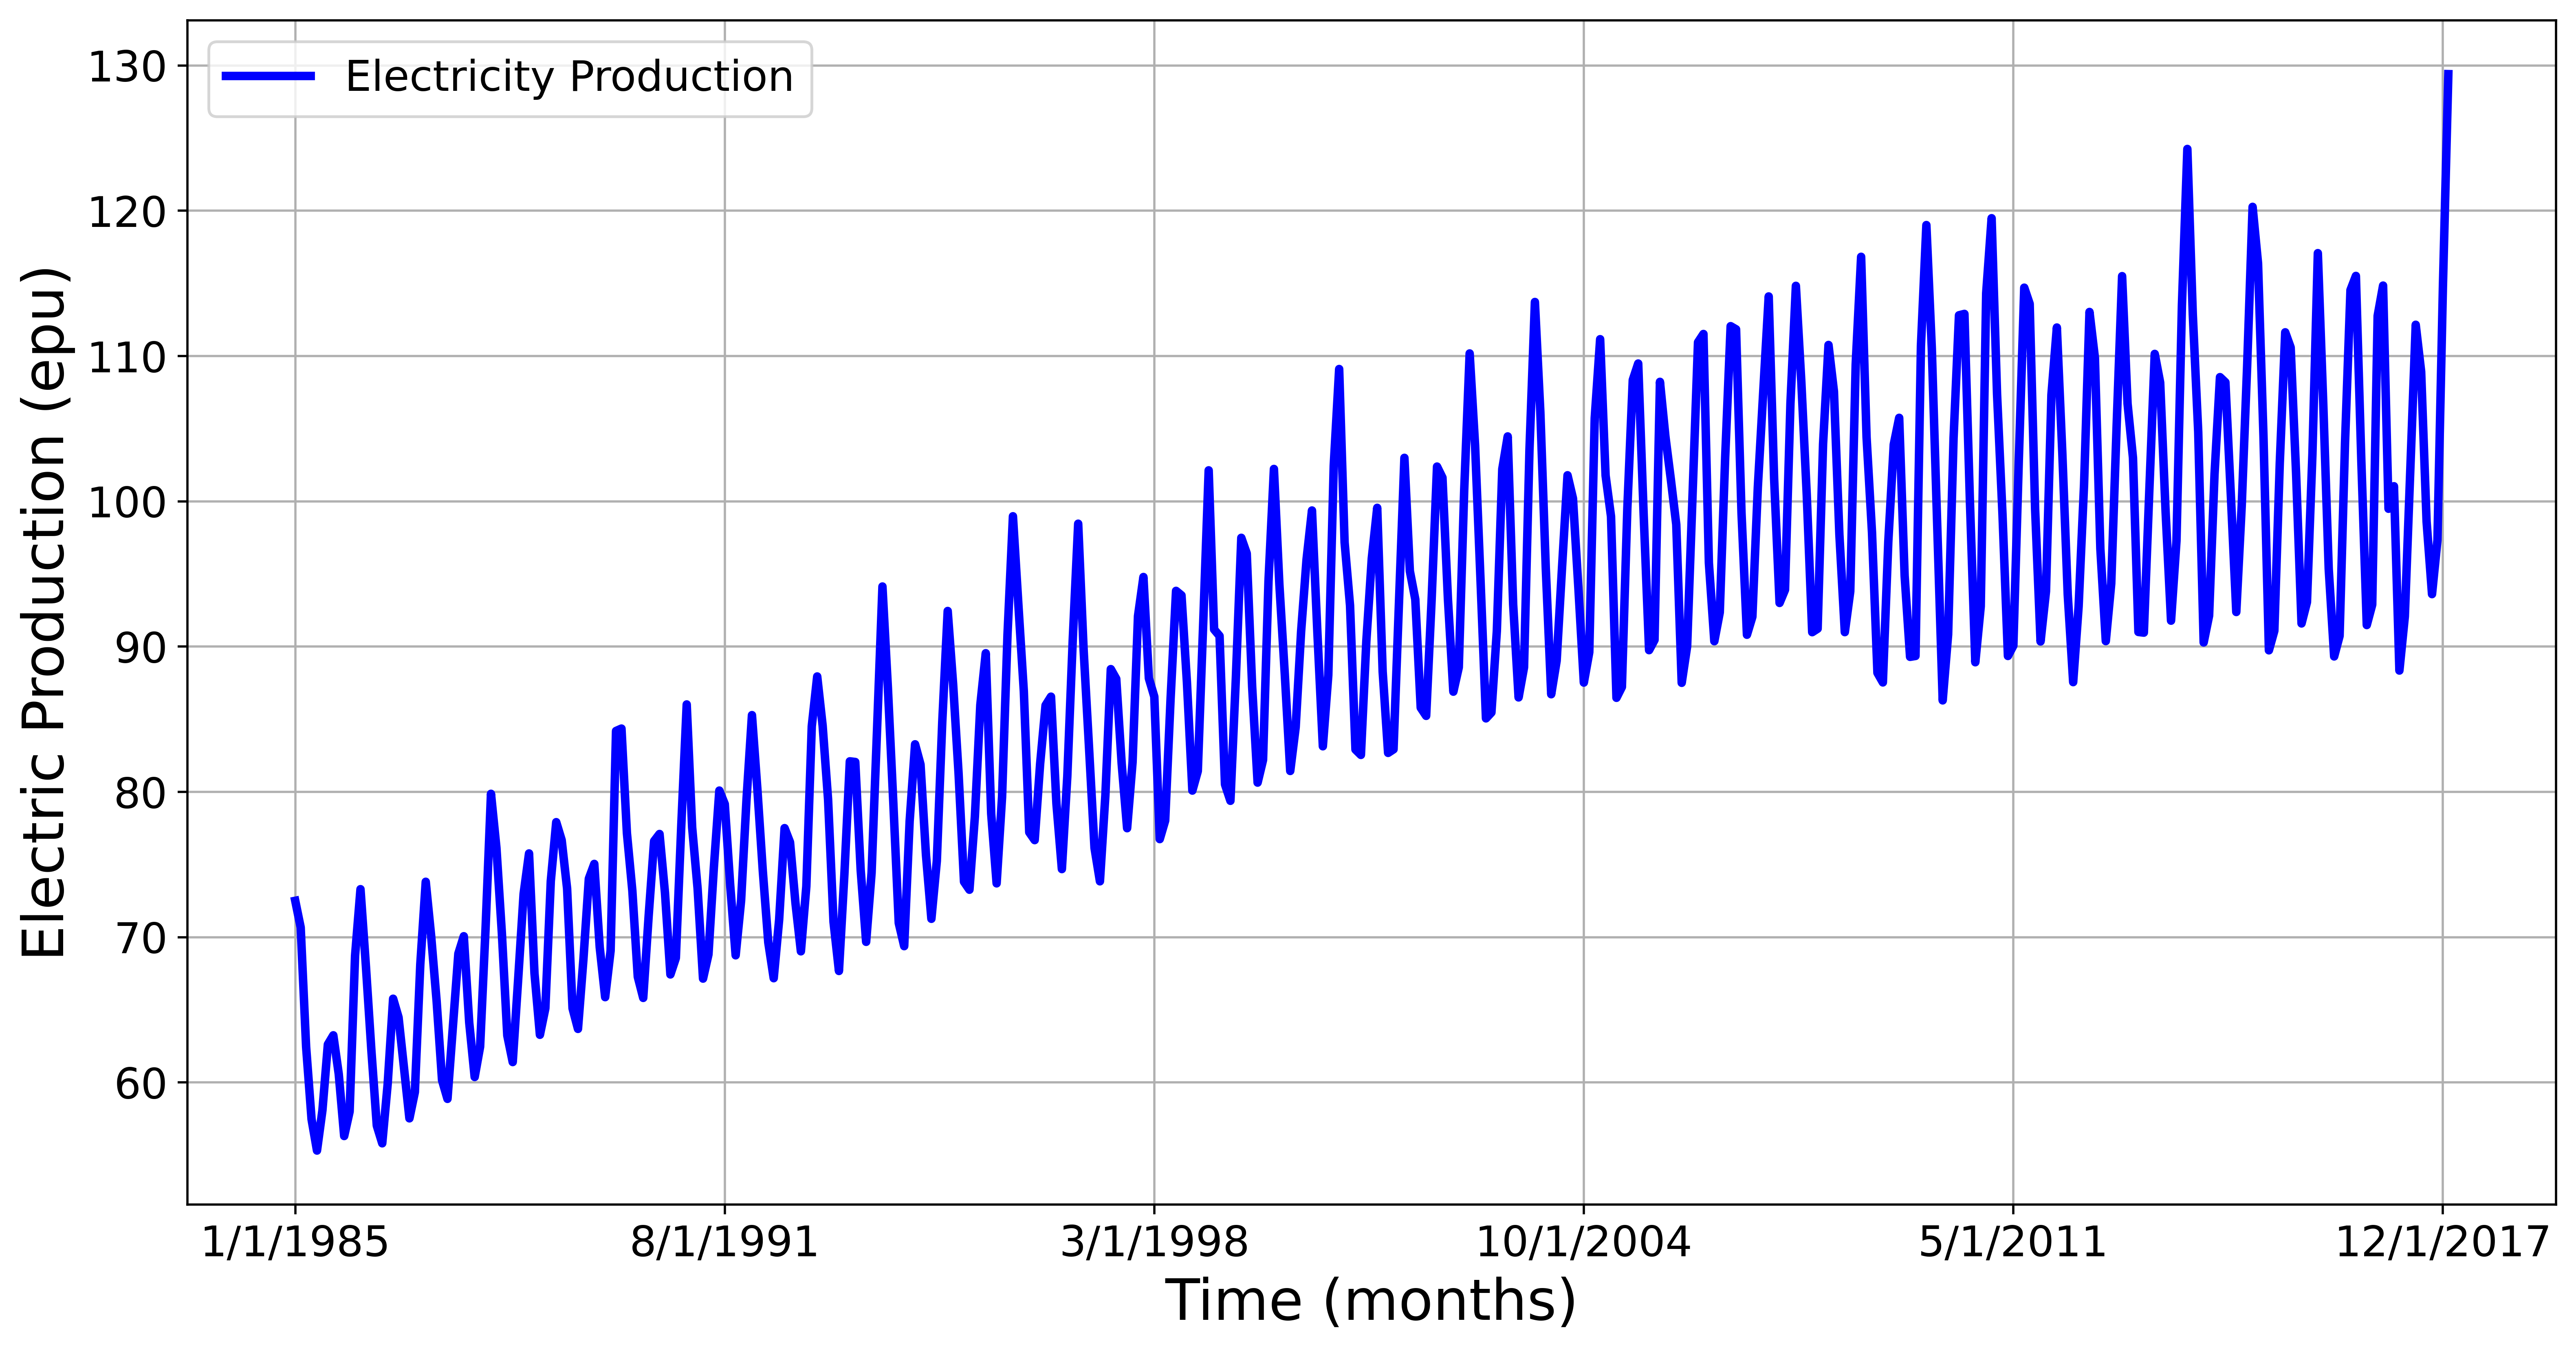

In [7]:
plt.figure(figsize=(15,7.7), dpi=500)
plt.xticks(fontsize=15)
plt.xticks(np.arange(0, len(data)+1, np.round(len(data)/5)))
plt.yticks(fontsize=15)
plt.grid()

plt.xlabel("Time (months)", fontsize=20)
plt.ylabel("Electric Production (epu)", fontsize=20)
plt.plot(data['Date'], data['Production'], 'b', label='Electricity Production', linewidth=3)
plt.legend(fontsize=15)


In [8]:
Y_KNN = []

#X_train, y_train, X_test, y_test = treating_dataset(name_series = df['fuel diff'], window=wandb.config.Window, N_splits = 5)
X_train, y_train, X_test, y_test = dataSpliting(pdSeries = dataSeries, window=window_, N_splits = 5)

# Initial weights
knn_model = KNeighborsRegressor(n_neighbors=neighbors_)

# fit grid search
knn_model.fit(X_train, y_train)

count=0

#model predict
y_predict_knn = knn_model.predict(X_test)

#RMSE
#rmse_RLS = mean_squared_error(y_test[1:-1], Y_RLS[2:], squared=False)
rmse_KNN = mean_squared_error(y_test[1:-2], y_predict_knn[1:-2], squared=False)
RMSE_KNN.append(rmse_KNN)

#MAE
#mae_RLS = mean_absolute_error(y_test[1:-1], Y_RLS[2:])
mae_KNN = mean_absolute_error(y_test[1:-2], y_predict_knn[1:-2])
MAE_KNN.append(mae_KNN)

In [9]:
figure2 = make_subplots(specs=[[{"secondary_y": True}]])

figure2.add_trace(
    go.Scatter(y=y_test[1:-2], name='True'),
    secondary_y=False
)

figure2.add_trace(
    go.Scatter(y=y_predict_knn[1:-2], name='kNN'),
    secondary_y=False
)

figure2.update_layout(
    title="Comparison "
)

figure2.update_xaxes(title='Time (seconds)')

figure2.show()

## WandB importing:

In [ ]:
#!pip install wandb

In [ ]:
os.environ["WANDB__SERVICE_WAIT"] = "1000000"

In [ ]:
!wandb login 40f0acf51f839c9bfbed5c1f24e945ed8245e110

In [ ]:
# Initialize a new W&B run to track this job
run = wandb.init(project="TEDARegressor", job_type="dataset-creation")

In [ ]:
# Create a new artifact, which is a sample dataset
dataset = wandb.Artifact('Electric_Production.csv', type='dataset')
# Add files to the artifact, in this case a simple text file
dataset.add_file('Electric_Production.csv')
# Log the artifact to save it as an output of this run
run.log_artifact(dataset)

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

### Defining dictionaries:

In [ ]:
metric_dict = {
    'name': 'rmse_KNN',
    'goal': 'minimize'
    }

In [ ]:
parameters_dict = {
    #kNN
    'Window': {
      'values': [2, 3, 4, 5, 6] #5
    },    
    'n_neighbors': {
      'values': [2, 3, 5, 7, 9, 11, 15] #5x7 = 35
    },
    'weights': {
      'values': ['uniform', 'distance'] #5x7x2 = 70
    },
}

In [ ]:
seed = 41
sweep_config = {
    "method": "grid",
    "metric": metric_dict,
    "parameters": parameters_dict,

}
sweep_id = wandb.sweep(sweep_config, project="TEDARegressor")

In [ ]:
#KNN
RMSE_KNN = []
MAE_KNN = []

In [ ]:
def train():
    with wandb.init() as run:
        Y_KNN = []

        X_train, y_train, X_test, y_test = dataSpliting(pdSeries = dataSeries, window=wandb.config.Window, N_splits = 5)
       
        knn_model = KNeighborsRegressor(n_neighbors=wandb.config.n_neighbors, weights=wandb.config.weights)
        
        # fit grid search
        knn_model.fit(X_train, y_train)

        # create codecarbon tracker
        # codecarbon is too much verbose, change the log level for more info
        tracker = EmissionsTracker(log_level="critical")
        tracker.start()    

        #model predict
        y_predict_knn = knn_model.predict(X_test)

        # get co2 emissions from tracker
        # "CO2 emission (in Kg)"
        emissions = tracker.stop()
        # energy unit is kWh
        run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
        wandb.log({"Energy_Consumed": tracker.final_emissions_data.energy_consumed}) 

        # Calculating rmse:
        rmse_KNN = mean_squared_error(y_test[1:-2], y_predict_knn[1:-2], squared=False)
        RMSE_KNN.append(rmse_KNN)        
        run.summary['rmse_KNN'] = rmse_KNN
        wandb.log({"rmse_KNN": rmse_KNN})

        # Calculating mae:
        mae_KNN = mean_absolute_error(y_test[1:-2], y_predict_knn[1:-2])
        MAE_KNN.append(mae_KNN)        
        run.summary['mae_KNN'] = mae_KNN
        wandb.log({"mae_KNN": mae_KNN})


In [ ]:
wandb.agent(sweep_id, train)

# Sweep Analysis

## Visualization

Here, we can visualize the Sweep Results ðŸ‘€. We have use the **Parallel Coordinates Plot ðŸ”€** to map hyperparameter values to model metrics.
We've used to see the combinations of hyperparameters that led to the **best model performance ðŸ“Š**:


#### Sweep Data

![SweepData](results/KNNtoCompareWithTEDAEnsemble.png)

#### Now, we are going to look the model results:

In [10]:
df_knn_sweep = pd.read_csv("results/KNNtoCompareWithTEDAEnsemble.csv")
df_knn_sweep.head()

Name  Window  n_neighbors   weights  rmse_KNN   mae_KNN  \
0    deep-sweep-5       2            5   uniform  6.193248  4.564043   
1  serene-sweep-7       2            7   uniform  5.976347  4.545920   
2   vivid-sweep-4       2            3  distance  6.163397  4.755398   
3  golden-sweep-9       2            9   uniform  6.053858  4.630792   
4  frosty-sweep-8       2            7  distance  6.087496  4.642069   

   Energy_Consumed  
0     8.520948e-09  
1     4.259450e-09  
2     1.290019e-08  
3     7.021949e-09  
4     1.262169e-08

### RMSE

In [11]:
min(df_knn_sweep['rmse_KNN'])

3.7034920746915674

### Best hyperparameter setup:

In [12]:
df_knn_sweep[df_knn_sweep['rmse_KNN']==min(df_knn_sweep['rmse_KNN'])]

Name  Window  n_neighbors   weights  rmse_KNN   mae_KNN  \
59  different-sweep-64       6            7  distance  3.703492  2.796535   

    Energy_Consumed  
59     2.501403e-08

In [13]:
max(df_knn_sweep['rmse_KNN'])

6.61977095619506

In [14]:
np.mean(df_knn_sweep['rmse_KNN'])

4.728578745169236

#### MAE

In [15]:
min(df_knn_sweep['mae_KNN'])

2.7965354234112234

In [16]:
max(df_knn_sweep['mae_KNN'])

4.945628809657393

In [17]:
np.mean(df_knn_sweep['mae_KNN'])

3.5622774710525387

#### Energy Consumed

In [18]:
min(df_knn_sweep['Energy_Consumed'])

3.852959143210278e-09

In [19]:
np.mean(df_knn_sweep['Energy_Consumed'])

1.72758637192027e-08

In [20]:
max(df_knn_sweep['Energy_Consumed'])

3.3498935343232005e-07